In [1]:
import pandas
import seaborn

import cltrier_lib

import twon_agents

In [2]:
SEED: int = 1
DATA_PATH: str = "../../../data"

In [3]:
post_ids: pandas.DataFrame = pandas.read_csv(
    f"{DATA_PATH}/interim/twitter.english.posts.csv", index_col=0
)[["id"]]
post_ids

,id
12,1692273284526555392
15,1692224923949805824
17,1691854007113842688
18,1691854006153347072
19,1691854005176074496
...,...
91766,1506739661519081472
91767,1506722331510591488
91768,1506682090124947712
91773,1505981160790315008


In [4]:
replies: pandas.DataFrame = (
    pandas.concat(
        [
            pandas.read_csv(f"{DATA_PATH}/raw/twitter.english/USReplies_2023_1.csv"),
            pandas.read_csv(f"{DATA_PATH}/raw/twitter.english/USReplies_2023_2.csv"),
            pandas.read_csv(f"{DATA_PATH}/raw/twitter.english/USReplies_2023_July.csv"),
            pandas.read_csv(
                f"{DATA_PATH}/raw/twitter.english/USReplies_2023_August_I.csv"
            ),
            pandas.read_csv(
                f"{DATA_PATH}/raw/twitter.english/USReplies_2023_August_II.csv"
            ),
        ]
    )
    .rename(
        columns={
            "tweet_id": "id",
            "full_text": "text",
            "screen_name": "username",
            "original_user_id": "author_id",
        }
    )
    .pipe(
        lambda _df: _df.assign(
            reply_to_id=pandas.to_numeric(_df["reply_to_id"], errors="coerce")
            .fillna(0)
            .astype("int64"),
            author_id=pandas.to_numeric(_df["author_id"], errors="coerce")
            .fillna(0)
            .astype("int64"),
        )
    )
    .pipe(twon_agents.data.filter_tweets, remove_w_mentions=False)
    .merge(post_ids, left_on="reply_to_id", right_on="id")
    .drop(columns=["id_x"])
    .rename(columns={"id_y": "id"})
)
replies

/tmp/ipykernel_3079064/2900875952.py:7: DtypeWarning: Columns (2,3,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  pandas.read_csv(f"{DATA_PATH}/raw/twitter.english/USReplies_2023_August_II.csv"),


,text,created_at,username,author_id,retweeted_user_ID,collected_at,reply_to_id,reply_to_user,expandedURL,id
0,@SenRickScott Funny that Hunter is being held ...,2023-07-26 16:11:33+00:00,finkleisin1,1088163738950295552,NaN,2023-08-07 12:19:48.140046,1684217285567807488,1.315461e+08,[],1684217285567807488
1,@SenRickScott @JoeBiden You’re lying,2023-07-21 19:48:03+00:00,finkleisin1,1088163738950295552,NaN,2023-08-07 12:19:48.140187,1682471504880050176,1.315461e+08,[],1682471504880050176
2,@SenRickScott Why don’t you call Senator Tubbe...,2023-07-21 11:58:42+00:00,finkleisin1,1088163738950295552,NaN,2023-08-07 12:19:48.140215,1682337371126112512,1.315461e+08,[],1682337371126112512
3,@SenRickScott OK folks let’s get your shot gla...,2023-07-20 12:12:32+00:00,finkleisin1,1088163738950295552,NaN,2023-08-07 12:19:48.140254,1681994109094080512,1.315461e+08,[],1681994109094080512
4,@SenRickScott @JoeBiden Blah blah blah,2023-07-18 22:18:28+00:00,finkleisin1,1088163738950295552,NaN,2023-08-07 12:19:48.140306,1681424977076322304,1.315461e+08,[],1681424977076322304
...,...,...,...,...,...,...,...,...,...,...
7084,@MarshaBlackburn I'll guarantee that if any on...,2023-06-24 18:52:08+00:00,jpkeaney111,1411161121,NaN,2023-08-15 22:59:42.190105,1672603841127170048,2.781456e+08,[],1672603841127170048
7085,@LindseyGrahamSC Most Republicans threw away t...,2023-06-11 18:37:40+00:00,jpkeaney111,1411161121,NaN,2023-08-15 22:59:42.190152,1667892656184127488,4.328953e+08,[],1667892656184127488
7086,@MarshaBlackburn Because our legal system suck...,2023-08-05 22:06:39+00:00,MRSCTS,28261183,NaN,2023-08-15 23:00:37.874757,1687486482334855168,2.781456e+08,[],1687486482334855168
7087,"@LindseyGrahamSC Republicans AGAINST tRUMP, Vo...",2022-11-16 16:15:36+00:00,MRSCTS,28261183,NaN,2023-08-15 23:00:37.875276,1592717086605852672,4.328953e+08,[],1592717086605852672


In [6]:
(
    replies
    # remove linebreaks and mentions at beginning
    .assign(
        text=(
            replies["text"]
            .replace(r"\n", " ", regex=True)
            .replace(r"^@(\w){1,15}\s?(@(\w){1,15})*", "", regex=True)
        )
    )[["id", "author_id", "reply_to_id", "created_at", "text"]].to_csv(
        f"{DATA_PATH}/interim/twitter.english.replies.csv"
    )
)

In [7]:
classified_data = pandas.json_normalize(
    [
        sample.model_dump()
        for sample in cltrier_lib.classify.Pipeline()(
            list(replies["text"]), threshold=0.0
        )
    ]
)
classified_data

,sample,results.topics.arts_&_culture,results.topics.business_&_entrepreneurs,results.topics.celebrity_&_pop_culture,results.topics.diaries_&_daily_life,results.topics.family,results.topics.fashion_&_style,results.topics.film_tv_&_video,results.topics.fitness_&_health,results.topics.food_&_dining,...,results.emotions.trust,results.sentiment.negative,results.sentiment.neutral,results.sentiment.positive,results.irony.non_irony,results.irony.irony,results.offensive.non-offensive,results.offensive.offensive,results.hate.NOT-HATE,results.hate.HATE
0,@SenRickScott Funny that Hunter is being held ...,0.004594,0.008285,0.087160,0.029363,0.002114,0.001370,0.017695,0.002530,0.000685,...,0.010898,0.855238,0.567307,0.071697,0.654130,0.492111,0.599178,0.408243,0.922140,0.093070
1,@SenRickScott @JoeBiden You’re lying,0.004184,0.007051,0.021803,0.038111,0.001693,0.000750,0.009050,0.001899,0.000715,...,0.006013,0.865124,0.523491,0.087414,0.716474,0.403851,0.458142,0.545130,0.921664,0.079799
2,@SenRickScott Why don’t you call Senator Tubbe...,0.002757,0.009989,0.011173,0.019284,0.001986,0.000871,0.009970,0.004246,0.001188,...,0.015460,0.870911,0.592832,0.068971,0.567786,0.557802,0.670921,0.331639,0.944034,0.060106
3,@SenRickScott OK folks let’s get your shot gla...,0.007143,0.006000,0.050380,0.069554,0.002991,0.001309,0.035088,0.016133,0.001173,...,0.007702,0.798012,0.532719,0.124256,0.435422,0.690576,0.369387,0.632775,0.104382,0.820708
4,@SenRickScott @JoeBiden Blah blah blah,0.002984,0.006402,0.016547,0.036641,0.001390,0.000607,0.008477,0.001865,0.000722,...,0.006437,0.653791,0.615997,0.160332,0.663486,0.460644,0.667798,0.326713,0.931599,0.070495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7084,@MarshaBlackburn I'll guarantee that if any on...,0.006638,0.009174,0.036548,0.096869,0.011989,0.001224,0.010547,0.003471,0.001582,...,0.087589,0.872785,0.581374,0.077001,0.729296,0.414593,0.677317,0.339869,0.891744,0.104780
7085,@LindseyGrahamSC Most Republicans threw away t...,0.003912,0.007931,0.019829,0.039706,0.001887,0.000903,0.009200,0.002047,0.000737,...,0.006242,0.849965,0.577780,0.073510,0.551065,0.567087,0.613153,0.384387,0.925583,0.078291
7086,@MarshaBlackburn Because our legal system suck...,0.003815,0.008609,0.014450,0.026150,0.001984,0.000942,0.009646,0.003475,0.000910,...,0.008920,0.925508,0.386424,0.060977,0.223821,0.818473,0.419502,0.603308,0.830747,0.149442
7087,"@LindseyGrahamSC Republicans AGAINST tRUMP, Vo...",0.003585,0.006879,0.014228,0.025658,0.001697,0.000836,0.008521,0.002415,0.000735,...,0.006131,0.881001,0.411115,0.109875,0.621280,0.454778,0.668525,0.340344,0.905233,0.095174


<Axes: xlabel='value', ylabel='variable'>

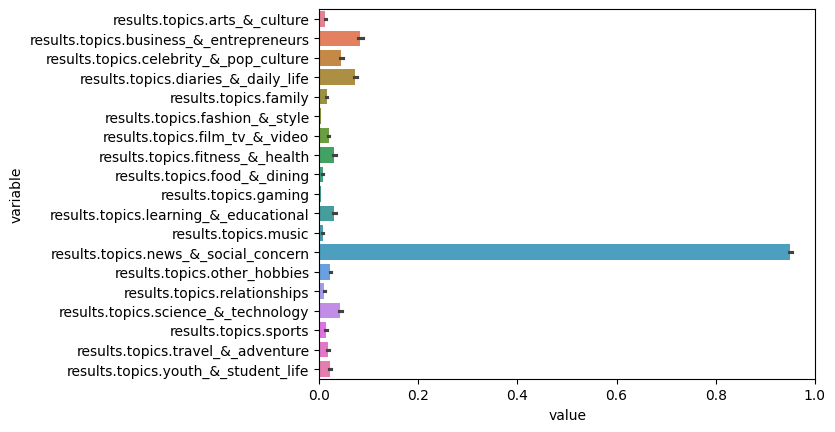

In [8]:
seaborn.barplot(
    classified_data.filter(like=".topics.").melt(),
    x="value",
    y="variable",
    hue="variable",
)

<Axes: xlabel='value', ylabel='variable'>

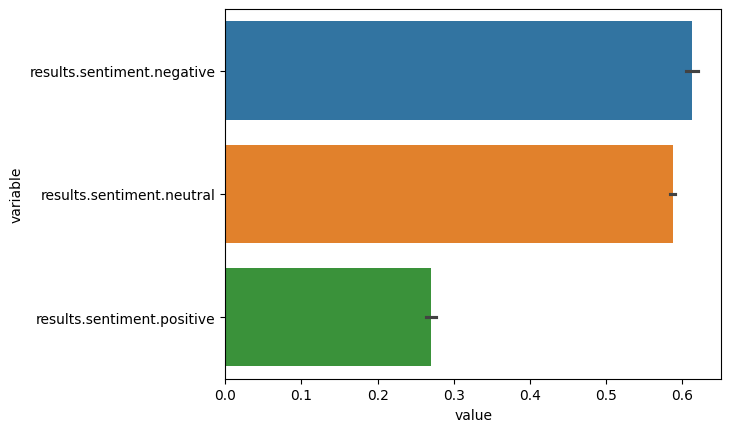

In [9]:
seaborn.barplot(
    classified_data.filter(like=".sentiment.").melt(),
    x="value",
    y="variable",
    hue="variable",
)

<Axes: xlabel='value', ylabel='variable'>

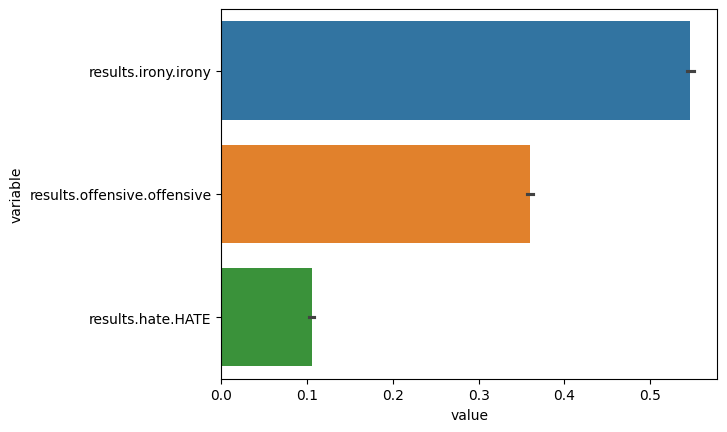

In [10]:
seaborn.barplot(
    classified_data.filter(regex="irony\.irony|offensive\.offensive|hate\.HATE").melt(),
    x="value",
    y="variable",
    hue="variable",
)